# Purpose

Initial:
- Get a framework to visualize ARK investing data (Ex: What are they buying/selling, what sectors?)

To-do List:
- Date is currently a string causing `1/8` to be larger than `1/11` <br>
    -__CANNOT__ fix at the source (ie: `update_arkfunds` database) because sqlite3 does not have a datetime format to save into (Only text, int, real).
    - Solution is to convert to datetime as needed (in the individual functions that require it)
- `ticker_lookup` errors for `FATE` ... need to probably generate df[df['ticker']] instead of df[(df[date])&(df[ticker])]
    - By subsetting to ticker specific -- can then extract the dates to standardize the X-axis (which prevets the current issue)
- `Change_in_portfolio` computes changes + new positions + closed positions ... however the date of a new position would be great (as well as date of a closed position)
- Micro/Small/Mid/Large cap designations for all tickers
- Create an alert system for Micro/Small cap investments

End game is to answer questions:
- Alerts when they buy penny stocks (Lo-cap)
     - May need FinViz connection
- Statistics on the follow:
    - How much is the average drawdown of a position?
    - How long does it take (on average) for a position to be decently positive (>10%)?
    - ???

In [1]:
def set_dir(path = "E:\OneDrive - Georgia Institute of Technology\Desktop\ARK Fund CSV Files"):
    import os
    os.chdir(path)
set_dir()

In [2]:
def see_data(db=0): #Function to view the data in the database easily
    import sqlite3
    import pandas as pd
    
    set_dir()
    
    if db == 0:
        db_name = "ARKFund.db"
        db_table = "arkfunds"
    elif db == 1:
        db_name = "sectors.db"
        db_table = "sectors"
        
    conn = sqlite3.connect(db_name) #Connect
    df = pd.read_sql_query('SELECT * FROM ' + db_table,conn)
    #display(df) #Print all data
    conn.close()
    return df

In [3]:
def update_sectors(df):
    '''
    Function to check if any new unique tickers exist
    -- If not, do nothing
    -- If so,
    ---- Utilize finviz to find sector info for ticker
    ---- Update the sectors.db to include this unique ticker
    '''
    import finviz
    import os
    import sqlite3
    import pandas as pd

    set_dir()
    
    if "sectors.db" in os.listdir():
        #Connect to db
        conn = sqlite3.connect('sectors.db')

    else:
        #Create db
        conn = sqlite3.connect('sectors.db') #Yes ... its the same line of code to connect or create

        #Create cursor
        c = conn.cursor()

        #Define table structure
        c.execute('''CREATE TABLE sectors (ticker TEXT, sector TEXT)''')
        conn.commit() #save

    print("--- Connection to sector db established ---")

    #Grab db info
    sector_tickers = pd.read_sql_query("SELECT * FROM sectors ORDER BY ticker",conn)
    
    if len(df) < 1: #No df to process
        #Find all unique tickers in the database
        data_to_process = False
    else:
        data_to_process = True
    
    if data_to_process:
        tickers = df['ticker'].unique() 

        missing = []
        print("New tickers: ")
        for i in tickers:
            if i not in sector_tickers['ticker'].unique():
                missing.append(i) #Add all new tickers to "missing"
                print("\t%s found"%i)

        sector = []
        if len(missing) < 1:
            print("\tNo new tickers to update")
        else:
            print("Searching sector info for: ")
            for i in missing: #For each ticker missing, attempt to find the sector for it
                print("\t"+i+" --- ",end='')
                try:
                    sec = finviz.get_stock(i)['Sector']
                except:
                    sec = "NA" #Some tickers like "ARCT UQ" will not pull up a result
                sector.append(sec)
                print(sec)

        #Update the df
        sector_tickers = sector_tickers.append(pd.DataFrame({'ticker':missing,'sector':sector}),ignore_index=True)

        #Format the df a bit
        sector_tickers = sector_tickers.reset_index(drop=True) #Reset index
        sector_tickers = sector_tickers.sort_values(by='ticker') #sort by ticker

        #Update the db
        sector_tickers.to_sql(name='sectors', con=conn, if_exists='replace', index=False)

        conn.commit() #Save
        print("Sector information has been updated")
    
    #Close connections   
    conn.close()
    print("Connection to sectors.db has been closed")
    
    return sector_tickers

In [4]:
def backup_data():
    '''
    Run every so often to backup the ARKFunds.db and Sectors.db files
    '''
    from shutil import copyfile
    import datetime
    
    today = datetime.datetime.today()
    
    if today.weekday() == 4: #If day of week is Friday
        print("Backing up databases because it is Friday")
        copyfile("ARKFund.db","Backups/"+today.date().isoformat()+" ARKFund.db")
        copyfile("sectors.db","Backups/"+today.date().isoformat()+" sectors.db")
        print("Data has been backedup for today: ",today.date().isoformat())
    else:
        pass

In [5]:
def capitalization(ticker): #Determine cap size of company
    import finviz
    try:
        info = finviz.get_stock(ticker)['Market Cap'] #Get market cap

        #Split market cap to take only whole number
        l,r = info.split('.')
        valuation = int(l) #Left of the decimal place
        units = r[-1] #Units ("M" or "B")

        #Nano is less than 50M ... dont think i need to classify this though
        #Micro is anything 300M and less
        #Small is [300M,2B]
        #Mid is [2B,10B]
        #Large is everything else
        if units == "M":
            if valuation <300:
                cap = "Micro"
            else:
                cap = "Small"
        elif units == "B":
            if valuation < 2:
                cap = "Small"
            elif valuation <= 10:
                cap = "Mid"
            else:
                cap = "Large"
        elif units == "T": #Companies like AAPL are 2151B ... but just in case finviz ever updates to trillion
            cap = "Large"
        else:
            cap = "NA" #Catch case if something else shows up ... would have to assume Nano cap tbh, but just in case write NA.
    except:
        cap = "NA"
        valuation = "NA"
        units = ""
    return cap,str(valuation)+units #Cap = classification | MarketCap

In [6]:
def update_arkfund():
    import glob
    import os
    import sqlite3
    import csv
    import pandas as pd
    import finviz
    
    #Change directory
    set_dir()

    #Load all excel files & Concat together
    files = glob.glob("*.csv") #Find all

    if "ARKFund.db" in os.listdir():
        #Connect to db
        conn = sqlite3.connect('ARKFund.db')

        #Create cursor object
        c = conn.cursor()
    else:
        #Create db
        conn = sqlite3.connect('ARKFund.db') #Yes ... its the same line of code to connect or create

        #Create cursor
        c = conn.cursor()

        #Define table structure
        c.execute('''CREATE TABLE arkfunds 
            (date TEXT, fund TEXT, company TEXT, ticker TEXT, shares INTEGER, weight REAL, sector TEXT,cap TEXT, market_cap INT)
                ''')
        conn.commit() #save

    print("--- Connection to ARKFunds.db established ---")

    print("Processing %.0f files:"%len(files))

    existing_files = glob.glob("Processed\*.csv")
    existing_files = [i[10:] for i in existing_files]
    
    df_all = pd.DataFrame()
    new_data=False #Set default switch
    for file in files:
        if file not in existing_files:
            df = pd.read_csv(file) #Read csv file
            df_all = df_all.append(df) #Append to mega df
            new_data=True
            
    if new_data: #If there is data to process
        #Grab sector info
        #1) Check if there are any new unique tickers that havent existed before
        #2) Grab the info if new tickers
        sectors = update_sectors(df_all) #Use the function to update any ticker that didnt exist AND obtain df of [ticker,sector]
        
        #Match "Ticker" in arkfunds.db to "sector" from sectors.db
        sec = []
        for i in df_all['ticker']:
            try:
                sec.append(sectors[sectors['ticker']==i]['sector'].iloc[0])
            except:
                sec.append("NA")
        print("Updating ARKfund with Sector.db info")
        df_all['sector'] = sec #create a new column called "sector" by matching the `ticker` to `sector`
        
        #Convert date column into datetime object 
        #df_all['date'] = df_all['date'].astype("datetime64[ns]") 
        ###Does not work! -- SQLite3 can only accept types TEXT, INT, REAL ... this results in datetime --> TEXT upon saving
        
        print("Computing capitalization of new data")
        cap_designation = []
        valuation = []
        count = 2
        total = len(df_all['ticker'])
        for i in df_all['ticker']:
            if count%50 == 0 or count == total:
                print("\t%s/%s"%(count,total))
            c,m = capitalization(i)
            cap_designation.append(c)
            valuation.append(m)
            count += 1
        
        df_all['cap'] = cap_designation
        df_all['market_cap'] = valuation
        
        #Rename 'weight(%)' to 'weight'
        print("Renaming weight(%) to weight")
        df_all = df_all.rename(columns={"weight(%)":"weight"})

        #Update ARKFunds.db database
        print("Writing results to database")
        df_all.to_sql(name='arkfunds', con=conn, if_exists='append', index=False)

        conn.commit() #Save database
        
        #Now that all the work has been done, move the files (do this last to avoid double entry of files)
        for file in files:
            if file not in existing_files:    
                os.rename(file, "Processed/"+file) #Move csv file to the processed folder so it doesn't read next time
                print("\t%s has been uploaded"%file)
            else:
                print("\t%s already exists in the database"%file)
    else:
        print("No new data to process")
        sectors = see_data(1)

    conn.close() #Close SQLite Database connection
    print("--- Connection closed ---")
    print("SQL Database has been successfully updated.")
    
    #Backup servers as necessary (Current trigger is: Friday's)
    backup_data()
    
    return df_all,sectors

In [16]:
%%time
added_df,sectors = update_arkfund()

--- Connection to ARKFunds.db established ---
Processing 1 files:
--- Connection to sector db established ---
New tickers: 
	No new tickers to update
Sector information has been updated
Connection to sectors.db has been closed
Updating ARKfund with Sector.db info
Computing capitalization of new data
	50/238
	100/238
	150/238
	200/238
	238/238
Renaming weight(%) to weight
Writing results to database
	1-15-2021 ARK data.csv has been uploaded
--- Connection closed ---
SQL Database has been successfully updated.
Backing up databases because it is Friday
Data has been backedup for today:  2021-01-15
Wall time: 4.98 s


In [31]:
see_data(0)

,date,fund,company,ticker,shares,weight,sector,cap,market_cap
0,1/4/2021,ARKQ,APPLE INC,AAPL,150378,1.13,Technology,Large,2148B
1,1/4/2021,ARKW,APPLE INC,AAPL,427526,1.04,Technology,Large,2148B
2,1/4/2021,ARKF,APPLE INC,AAPL,339578,2.25,Technology,Large,2148B
3,1/4/2021,ARKG,ACCOLADE INC,ACCD,2378904,1.26,Healthcare,Mid,2B
4,1/4/2021,ARKW,ADOBE INC,ADBE,108819,1.00,Technology,Large,222B
...,...,...,...,...,...,...,...,...,...
1870,1/13/2021,ARKF,ZILLOW GROUP INC - C,Z,756554,4.61,Communication Services,Large,23B
1871,1/13/2021,ARKW,ZILLOW GROUP INC - C,Z,848254,1.95,Communication Services,Large,23B
1872,1/13/2021,ARKK,ZILLOW GROUP INC - C,Z,4578488,2.97,Communication Services,Large,23B
1873,1/13/2021,ARKW,ZOOM VIDEO COMMUNICATIONS-A,ZM,330102,1.94,Communication Services,Large,102B


In [79]:
see_data()

,date,fund,company,ticker,shares,weight,sector,Cap,Market Cap
0,1/11/2021,ARKQ,APPLE INC,AAPL,174614,1.02,Technology,Large,2151B
1,1/11/2021,ARKW,ROKU INC,ROKU,862104,5.94,Communication Services,Large,50B
2,1/11/2021,ARKK,ROKU INC,ROKU,3954968,7.63,Communication Services,Large,50B
3,1/11/2021,ARKG,REPARE THERAPEUTICS INC,RPTX,858284,0.38,Healthcare,Small,1B
4,1/11/2021,ARKF,SCHWAB (CHARLES) CORP,SCHW,530624,1.42,Financial Services,Large,115B
...,...,...,...,...,...,...,...,...,...
1394,1/8/2021,ARKF,JSC KASPI.KZ GDR-REG S,KSPI,44603,0.13,NA,NA,NA
1395,1/8/2021,ARKQ,KRATOS DEFENSE & SECURITY,KTOS,2727884,3.30,Industrials,Mid,3B
1396,1/8/2021,ARKF,LENDINGCLUB CORP,LC,1879598,0.95,Financial Services,Small,878M
1397,1/8/2021,ARKG,IONIS PHARMACEUTICALS INC,IONS,2600789,1.69,Healthcare,Mid,8B


In [32]:
df = see_data()
display(df)

,date,fund,company,ticker,shares,weight,sector,cap,market_cap
0,1/4/2021,ARKQ,APPLE INC,AAPL,150378,1.13,Technology,Large,2148B
1,1/4/2021,ARKW,APPLE INC,AAPL,427526,1.04,Technology,Large,2148B
2,1/4/2021,ARKF,APPLE INC,AAPL,339578,2.25,Technology,Large,2148B
3,1/4/2021,ARKG,ACCOLADE INC,ACCD,2378904,1.26,Healthcare,Mid,2B
4,1/4/2021,ARKW,ADOBE INC,ADBE,108819,1.00,Technology,Large,222B
...,...,...,...,...,...,...,...,...,...
1632,1/12/2021,ARKF,ZILLOW GROUP INC - C,Z,737257,4.73,Communication Services,Large,24B
1633,1/12/2021,ARKW,ZILLOW GROUP INC - C,Z,834123,2.00,Communication Services,Large,24B
1634,1/12/2021,ARKK,ZILLOW GROUP INC - C,Z,4541463,3.05,Communication Services,Large,24B
1635,1/12/2021,ARKK,ZOOM VIDEO COMMUNICATIONS-A,ZM,1182987,1.94,Communication Services,Large,99B


Change in sector investments comparing 1/4/2021 to 1/12/2021 (Negative = devesting out-of/ Positive = investing into)


sector
Communication Services   -0.21
Consumer Defensive       -0.11
Financial                -0.03
Healthcare                0.90
NA                        0.27
Technology               -0.43
Name: weight, dtype: float64

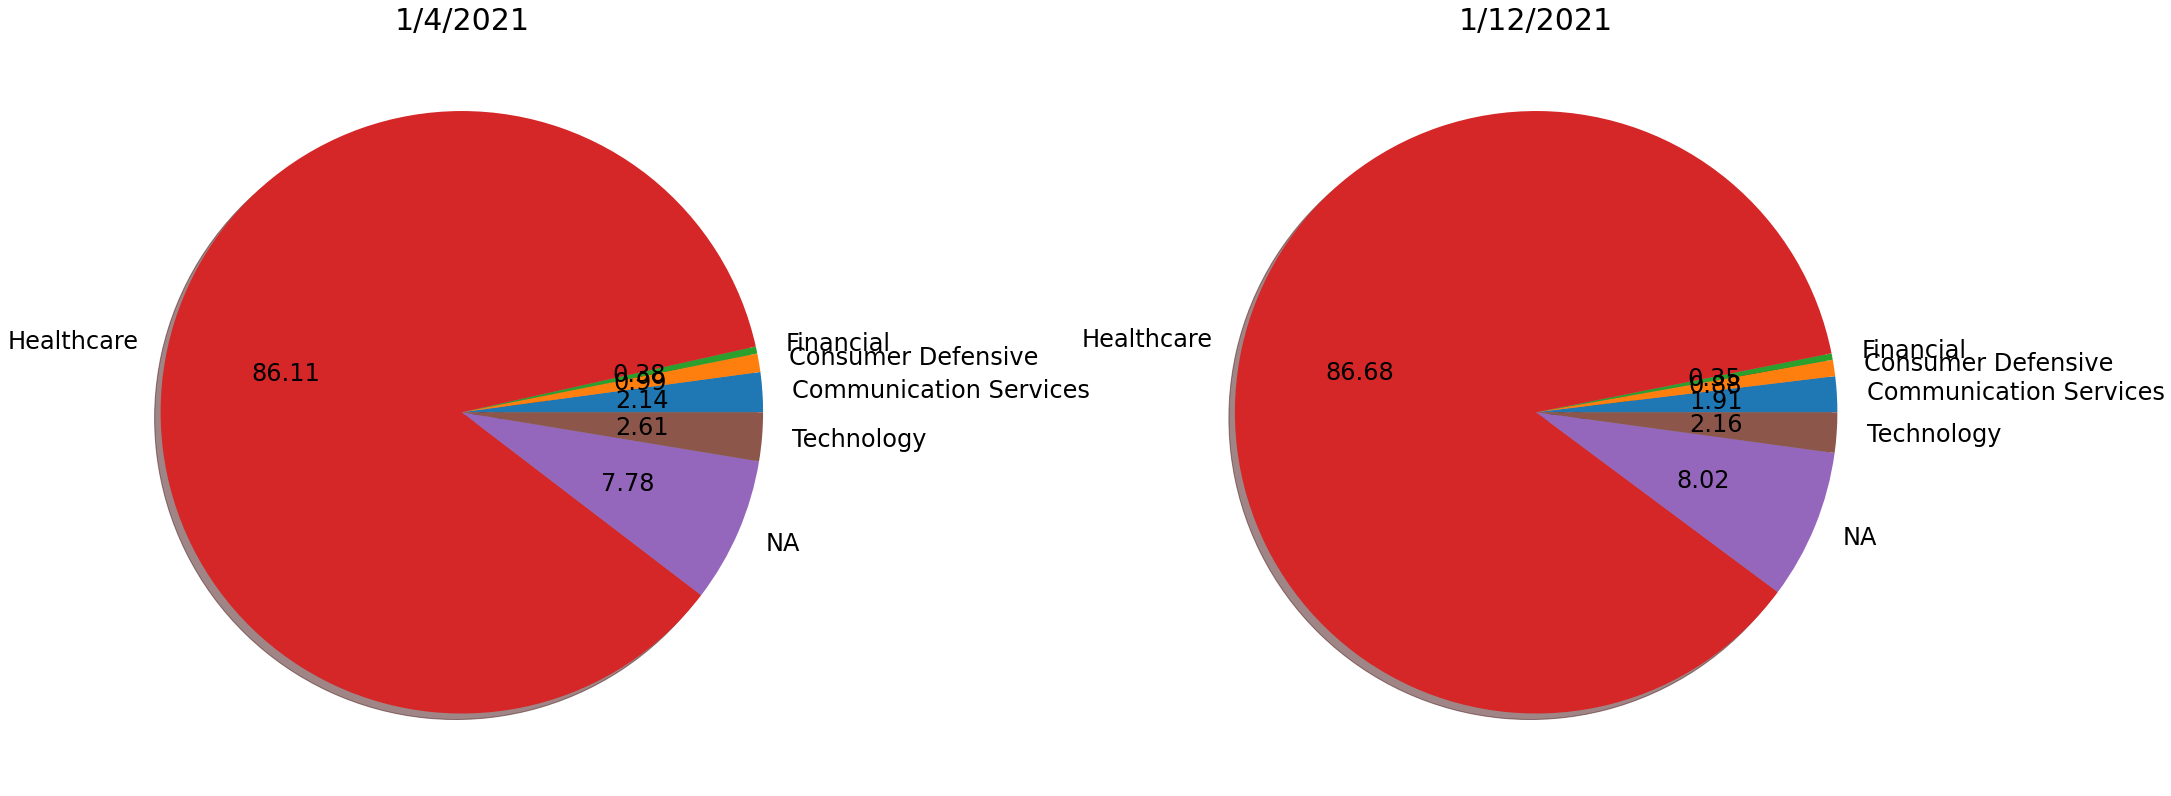

In [34]:
def portfolio_diff(date1,date2,fund="ARKG"):
    '''
    Get a snapshot difference between 2 differing portfolio dates
    
    date1 = initial date
    date2 = final date
    fund = which of the 5 ark funds (ARKQ,ARKW,ARKK,ARKF,ARKG)
    '''
    
    if len(date1)<6:
        date1 += "/2021"
    if len(date2)<6:
        date2 += "/2021"
    
    subset1 = df[(df['fund']==fund) & (df['date']==date1)]
    subset2 = df[(df['fund']==fund) & (df['date']==date2)]

    sectors = subset1['sector'].append(subset2['sector']).unique() #Unique sectors among the 2 requested queries

    subset2_diversity = subset2.groupby('sector').sum()['weight']

    def autopct_layout(val):
        import numpy as np
        return np.round(val,2)

    def pie_chart(subset,date):
        import matplotlib.pyplot as plt
        subset_diversity = subset.groupby('sector').sum()['weight']
        patches, texts, autotexts =  plt.pie(subset_diversity,labels=subset_diversity.index.to_list(),autopct=autopct_layout,shadow=True)
        for i in texts:
            i.set_fontsize(24) #Set font size of sector names
        for i in autotexts: 
            i.set_fontsize(24) #Set font size for the values
        plt.tight_layout()
        plt.title(str(date),fontsize=30)
        return subset_diversity

    import matplotlib.pyplot as plt
    import numpy as np
    plt.figure(figsize=(30,15))
    plt.subplot(1,2,1)
    a = pie_chart(subset1,date1)
    plt.subplot(1,2,2)
    b = pie_chart(subset2,date2)
    print("Change in sector investments comparing %s to %s (Negative = devesting out-of/ Positive = investing into)"%(date1,date2))
    display(b-a)
    return a,b #Return the differing portfolios

a,b = portfolio_diff('1/4',"1/12","ARKG")

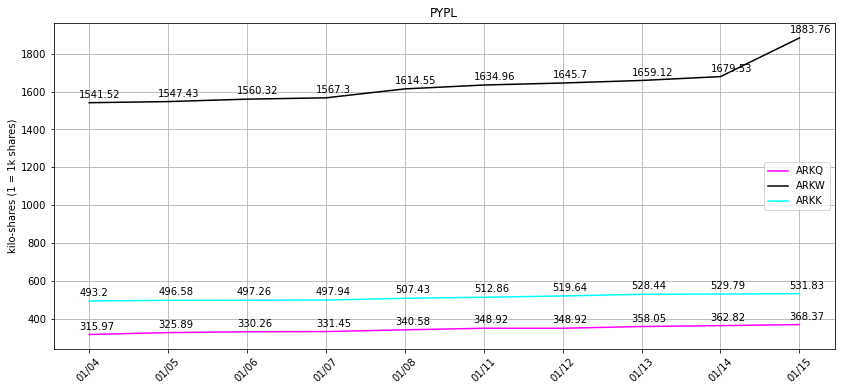

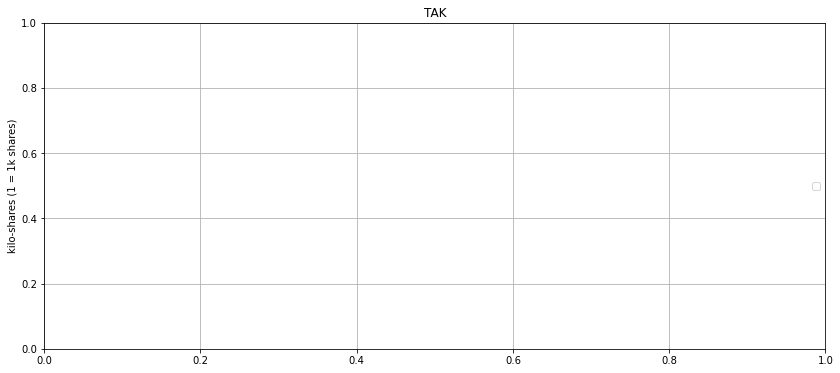

In [19]:
def ticker_lookup(tickers,together=True,funds=None):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import pandas as pd
    import datetime
    import numpy as np
    
    df = see_data() #Grab all data in ARKFund.db
    df['date'] = df['date'].astype('datetime64[ns]') #Convert date to datetime object so data can be sorted
    df = df.sort_values(['date'],ascending=True) #Sort by ascending date

    #Compute a date axis
    earliest_date = df.iloc[0]['date']
    latest_date = df.iloc[-1]['date']
    xrange = pd.date_range(earliest_date,latest_date).date #Create a range of dates between start and end
    xrange = [datetime.datetime.strftime(i,"%m/%d/%Y") for i in xrange] #Convert datetime object to string "01/04/2021"
    
    plot_count = len(tickers) #How many plots per fund
    
    colors = ['magenta','k','cyan','g','r','dark green','pink','orange','yellow'] #Color pallete choices

    if funds == None: #If no fund is provided, search all 5 funds
        funds = ["ARKQ","ARKW","ARKK","ARKF","ARKG"]

    def log_reduction(val): #Reduce the y-axis by a factor of X
        import numpy as np
        reduced = [np.round(i/1000,2) for i in val] #Reduce share size by factor of 1000
        return reduced
    def timestamp_to_MonthDay(lst): #Convert "2021-01-14 00:00:00" to "01/14" for all elements in a list
        return [i.strftime("%m/%d") for i in lst]
    
    if together:
        all_df = pd.DataFrame()
        i = 1

        for ticker in tickers:

            subset = df[df['ticker']==ticker.upper()].groupby('fund')
            plt.figure(figsize=(14,6))
            #plt.subplot(1,plot_count,i) #This would stack plots horizontally ... the above does it veritcally
            j = 0

            for _,r in subset:
                shares = log_reduction(r['shares'])
                dates = np.arange(0,len(shares)) #Create an arbitrary date axis from [0,n]
                plt.plot(dates,shares,label=ticker,color=colors[j])
                plt.xticks(dates,rotation=45,labels=timestamp_to_MonthDay(r['date'])) #Feed the arbirary axis with labels as the dates
                for idx,Y in enumerate(shares):
                    plt.annotate(str(Y),xy=(idx,Y),xytext=(-10,5),textcoords='offset points')
                j += 1
                all_df = all_df.append(r) #df to return in case its useful
                
            plt.title(ticker.upper())
            #plt.yticks([]) #Hide y-axis (already have the numbers on the data points) -- might turn this into a feature
            #For shared plot ... need y-axis and legend on all figures
            plt.ylabel("kilo-shares (1 = 1k shares)")
            plt.legend(labels=funds,loc="center right")
            plt.grid(axis='both')
            i += 1
    else:
        all_df = pd.DataFrame()
        i = 1
        plt.figure(figsize=(14,6))
        plot_count = len(funds) #How many plots per fund

        for fund in funds:

            subset = df[df['fund']==fund.upper()]
            plt.subplot(1,plot_count,i)
            j = 0

            for ticker in tickers:
                r = subset[subset['ticker']==ticker.upper()]
                shares = log_reduction(r['shares'])
                dates = np.arange(0,len(shares)) #Create arbitrary date axis
                plt.plot(dates,shares,label=fund,color=colors[j])
                plt.xticks(dates,rotation=45,labels=timestamp_to_MonthDay(r['date'])) #Feed in arbirary axis with labels as the dates
                for idx,Y in enumerate(shares):
                    plt.annotate(str(Y),xy=(idx,Y),xytext=(-10,5),textcoords='offset points')
                j += 1
                all_df = all_df.append(r) #df to return in case its useful

            plt.title(fund.upper())
            #plt.yticks([])
            plt.grid(axis='y')
            plt.tight_layout()
            if i == 1:
                plt.ylabel("kilo-shares (1 = 1k shares)")
            if i == plot_count:
                plt.legend(labels=tickers,loc="center right")
            i += 1
    return all_df
_ = ticker_lookup(tickers = ['pypl'],together=True)

In [98]:
def change_in_portfolio(date1,date2,fund=None):
    '''
    Functionality for `fund` argument built in ... but not fully tested
    '''
    import pandas as pd
    
    df = see_data(0) #Grab all data in SQL database
    df['date'] = df['date'].astype('datetime64[ns]') #Convert date to datetime object
    #If dates provided are short-hand .... add the year to them
    def add_year(date):
        import datetime
        year = datetime.datetime.today().year
        return date+"/"+str(year)

    if len(date1)<7:
        date1 = add_year(date1)
    if len(date2)<7:
        date2 = add_year(date2)
    
    if fund == None:
        #Grab subset info for the dates
        a = df[(df['date']==date1)]
        b = df[(df['date']==date2)]
    else:
        #Grab subset info for the specified fund
        a = df[(df['date']==date1)&(df['fund']==fund)]
        b = df[(df['date']==date2)&(df['fund']==fund)]
    
    diff = a.merge(b,how='outer',on=['fund','ticker'],indicator=False) #Determine differences between the 2 dates
    diff['change'] = diff['shares_y']-diff['shares_x'] #Compute change in shares
    
    diff = diff[['date_x','date_y','fund','ticker','shares_x','shares_y','change']] #Pick only select columns
    
    changes = diff.rename(columns={'shares_x':"shares_then","shares_y":"shares_now",
                                'date_x':"start_date","date_y":"end_date"}) #Rename for clarity
    
    ##### Compute a sliced df containing only dates between [date1,date2] for use in `new` and `closed` dfs
    #Convert string to datetime for the date column
#    dates = pd.to_datetime(df['date'],infer_datetime_format=True)
#    df['date'] = dates
    df = df.sort_values(by='date',ascending=True) #Sort ascending dates

    #Convert date arguments to datetime object
#    date1 = datetime.datetime.strptime(date1, '%m/%d/%Y')
#    date2 = datetime.datetime.strptime(date2, '%m/%d/%Y')

    #Subset the original df to be between these 2 dates
    df = df[(df['date']>=date1)&(df['date']<=date2)]
    
    ####Determine positions that are new
    new = changes[pd.isna(changes['shares_then'])] #All positions which didn't have shares before are new
    
    #Compute the date these positions opened
    initiation_date = []
    for i,row in new.iterrows():
        subset = df[(df['ticker']==row['ticker']) & (df['fund']==row['fund'])] #Find this subset in the sliced [date1,date2] df
        initiation_date.append(subset.iloc[0]['date'])

    new = new.drop(['shares_then','start_date','change','end_date'],axis=1) #Drop the useless information (NaN columns)
    new['initiation_date'] = initiation_date #Create a new column with the date of position start
    
    ####Determine positions that closed
    closed = changes[pd.isna(changes['shares_now'])] #All positions which no longer have shares are closed
    
    #Determine date the position(s) were closed
    sell_date = []
    for _,row in closed.iterrows():
        subset = df[(df['ticker']==row['ticker'])&(df['fund']==row['fund'])] #Find this subset in the sliced [date1,date2] df
        sell_date.append(subset['date'].iloc[-1])

    closed = closed.drop(['start_date','end_date','shares_now','change'],axis=1) #Drop unnecessary info (NaN Columns)
    closed['close_date'] = sell_date #Create column
    
    #Update Change df to not include new or closed positions
    changes = changes[pd.isna(changes['change'])==False] #Make the "changes" df have all changes that arent new/closed

    return changes, new, closed

changes, new, closed = change_in_portfolio('1/8','1/12')
print("Changes:")
display(changes)
print("New positions:")
display(new)
print("Closed positions:")
display(closed)

Changes:


,start_date,end_date,fund,ticker,shares_then,shares_now,change
0,2021-01-08,2021-01-12,ARKQ,AAPL,169634.0,176938,7304.0
1,2021-01-08,2021-01-12,ARKW,AAPL,439853.0,450419,10566.0
2,2021-01-08,2021-01-12,ARKF,AAPL,366052.0,375019,8967.0
3,2021-01-08,2021-01-12,ARKG,ACCD,2643355.0,2693664,50309.0
4,2021-01-08,2021-01-12,ARKW,ADBE,111969.0,114669,2700.0
...,...,...,...,...,...,...,...
228,2021-01-08,2021-01-12,ARKF,Z,719638.0,737257,17619.0
229,2021-01-08,2021-01-12,ARKW,Z,814539.0,834123,19584.0
230,2021-01-08,2021-01-12,ARKK,Z,4455565.0,4541463,85898.0
231,2021-01-08,2021-01-12,ARKK,ZM,847820.0,1182987,335167.0


New positions:


,fund,ticker,shares_now,initiation_date
233,ARKG,BMY,1469267,2021-01-11
234,ARKQ,EXPC,51339,2021-01-11
235,ARKQ,LMT,65254,2021-01-11
236,ARKK,REGN,106483,2021-01-11
237,ARKQ,TDY,60245,2021-01-11


Closed positions:


,fund,ticker,shares_then,close_date


In [42]:
changes[changes['ticker']=='HUYA']

,start_date,end_date,fund,ticker,shares_then,shares_now,change
67,2021-01-11,2021-01-12,ARKK,HUYA,6697052,6741052,44000
68,2021-01-11,2021-01-12,ARKW,HUYA,4582960,4643510,60550


In [52]:
#def alerts_significant_purchase():
'''
Goal: Alert if a position is significantly bought or sold (Maybe by metric of 10% increase/decrease in share size?)
'''
import datetime
df = see_data(0) #Load data

dates = sorted(df['date'].astype('datetime64[ns]').unique()) #Sort the unique dates

today = dates[-1].astype()
yesterday = dates[-2]

print(today,yesterday)


TypeError: Cannot interpret '<module 'datetime' from 'C:\\Users\\Brandon\\miniconda3\\envs\\tensorflowenv\\lib\\datetime.py'>' as a data type

In [48]:
today

AttributeError: 'numpy.str_' object has no attribute 'isoformat'

In [62]:
%%writefile app.py
import dash
import plotly
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output, State

#Load in dash app with external CSS elements
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

#Define some theme settings
colors = {
    'background': '#111111',
    'text': '#7FDBFF',
    'button':'#D6D8DC'
    }

app.layout = html.Div([
    html.Div(
        className="app-header",
        children=[
            html.Div('Plotly Dash', className="app-header--title")
        ]
    ),
    html.Div(
        children=html.Div([
            html.H5('Overview'),
            html.Div('''
                This is an example of a simple Dash app with
                local, customized CSS.
            ''')
        ])
    )
])

if __name__ == '__main__':
    app.run_server(debug=True,port=8050)

Writing app.py
